# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


# from sklearn.base import BaseEstimator, TransformerMixin
# 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



import optuna


import tqdm
import joblib
import pickle
# serializd your object and svaes its binary form 

import shap


pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')
# blue, orange, green

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# <span style="font-family:cursive;text-align:center">⬇️ Import Data</span>

In [2]:
train = pd.read_csv('/kaggle/input/widsdatathon2022/train.csv')
test = pd.read_csv('/kaggle/input/widsdatathon2022/test.csv')

In [3]:
df_train = train.copy()
df_test = test.copy()

In [4]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [5]:
train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34,44.650000,62,15,30.338710,46,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0,0,0,NaN,NaN

In [6]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

# df.columns = df.columns.values.lower()

# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    <font size='5pt'><b>Understanding features:</b></font>

year_Factor: anonymized year in which the weather and energy usage factors were observed  

state_Factor: anonymized state in which the building is located  

building_class: building classification  

facility_type: building usage type  

floor_area: floor area (in square feet) of the building  

year_built: year in which the building was constructed  

energy_star_rating: the energy star rating of the building  

elevation: elevation of the building location  

january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building  

january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building  

january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building  

[Similarly for all other months]

cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature   
exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature   falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.  

precipitation_inches: annual precipitation in inches at the location of the building  

snowfall_inches: annual snowfall in inches at the location of the building  

snowdepth_inches: annual snow depth in inches at the location of the building  

avg_temp: average temperature over a year at the location of the building  

days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building  

days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building  

days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building  

days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building  

days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building  

days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building  

days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building  

days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building  

direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).  

max_wind_speed: maximum wind speed at the location of the building  

days_with_fog: number of days with fog at the location of the building  

building_id: building id  
<br>
<font size='5pt'><b>Target</b></font><br>
site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills 

In [7]:
numerical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df_train[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df_train.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 61
Discrete feature Count 6
Continuous feature Count 55
Categorical feature Count 3


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [9]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [10]:
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


In [11]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [12]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [13]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


In [14]:
df_test[['year_factor', 'days_above_110F']]

,year_factor,days_above_110F
0,7,0
1,7,0
2,7,0
3,7,0
4,7,0
...,...,...
9700,7,0
9701,7,0
9702,7,0
9703,7,0


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
   
1) `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   
2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.   
3) There are no duplicates in individual dataset, however there might be duplicates in the combined version   
4) there are no constant columns in train dataset, but test dataset has 2 constant columns   

###  <span style="font-family:cursive;text-align:center">combine the datasets for the visualizations</span>

In [15]:
test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'


# train = commondf["dataset"]  == "train"

df_all = pd.concat([train, test], axis=0, ignore_index=True)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.</div>

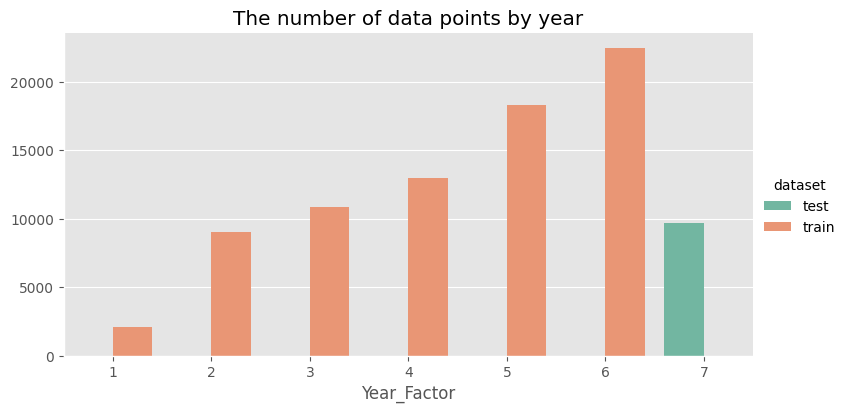

In [16]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

# encoded (morphed) value of original year

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set contains data points of 7 states, however, `test` doesn't have any data point from `State_6`.</div>

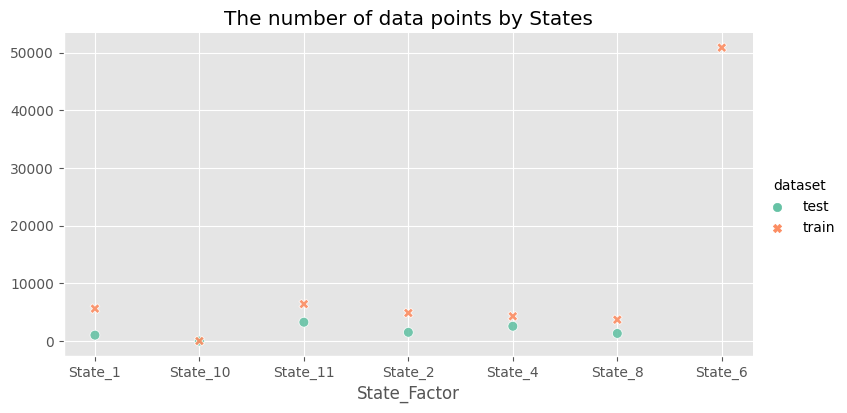

In [17]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

In [18]:
# df_test["state_factor"].unique()

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Both residential and commercial buildings are present in both datasets. `train` data contains more residential buildings compared to `test` set which is due to the number of`State_6` buildings in `train` set which seems to add to the number. Apart from `State_6`, the number of commercial buildings are higher than the residential buildings and `State_10` only contains commercial buildings. The type of building and state could be important factors in determining `EUI`.</div>

Text(0.5, 0, '')

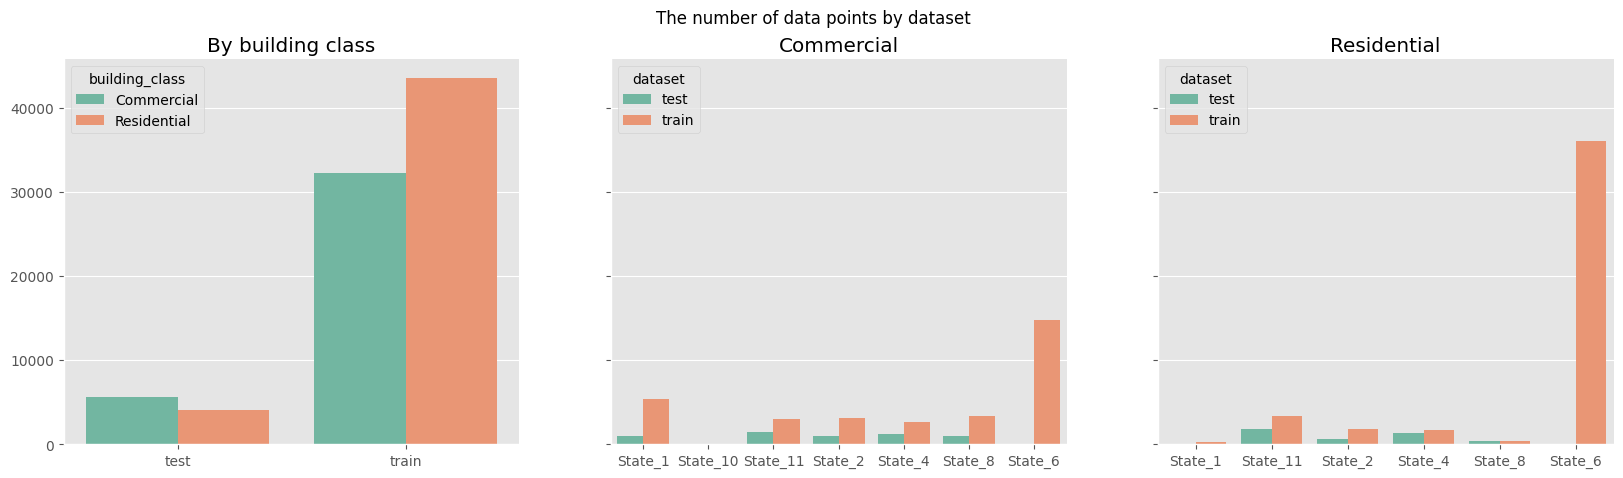

In [19]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">All facility types are present in both datasets. Almost 90% of residential `Multifamily_uncategorized` buildings and 50% of `Office_uncategorized` are in `State_6` of the training set. Not quite sure how `State_6` will affect the model learning and prediction.</div>

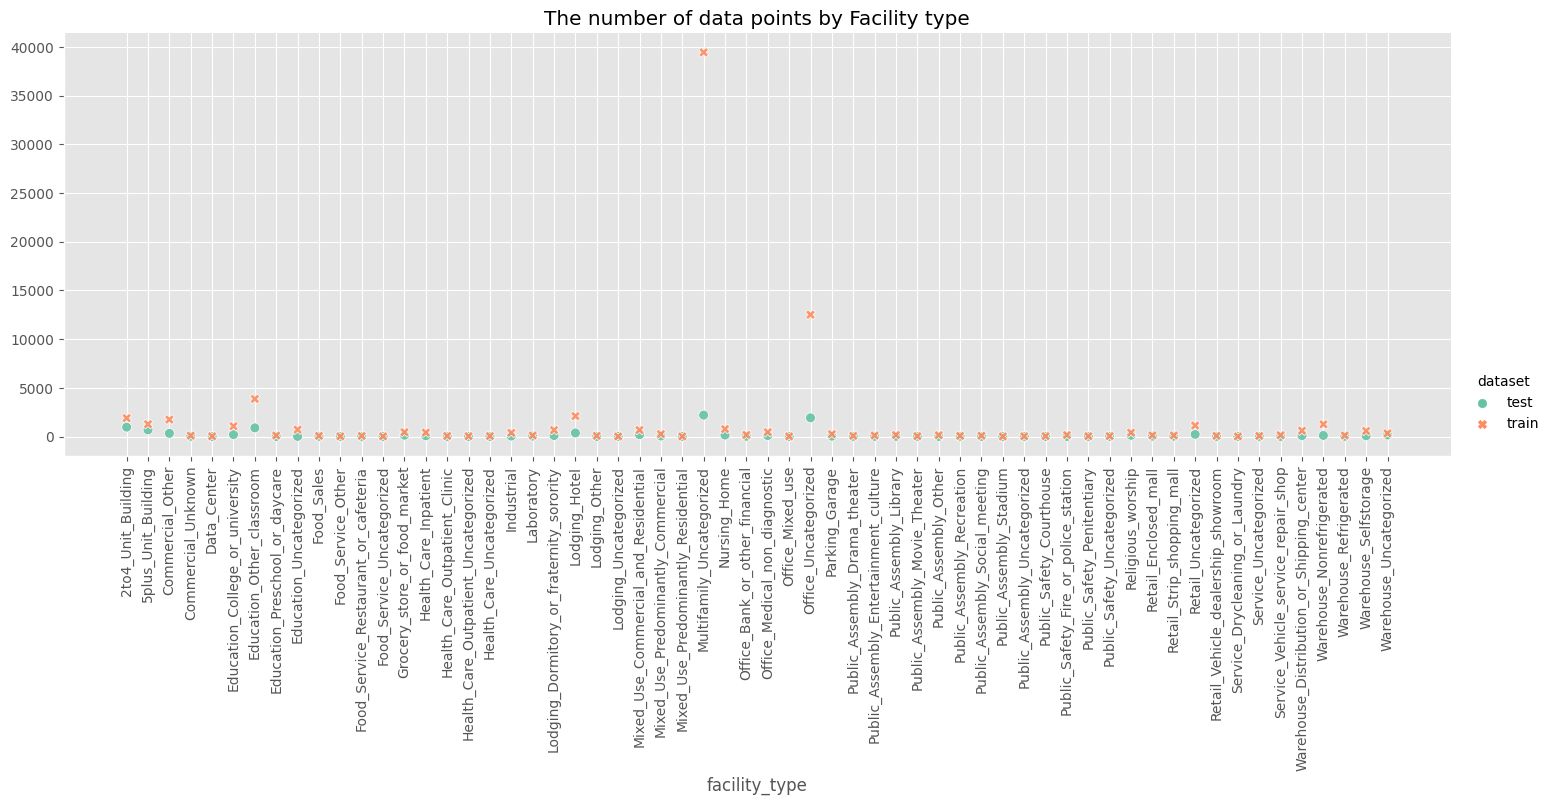

In [20]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The oldest building was built in 1600 and the latest in 2016. The majority of the buildings were built since 1900. There were some 0 and null values. Not quite sure what 0 signifies.</div>

In [21]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

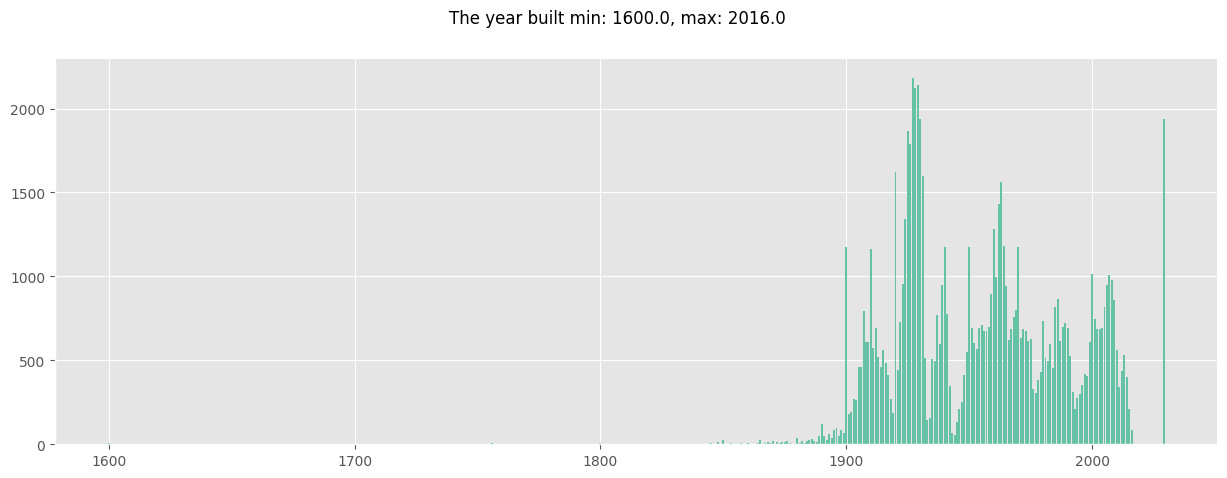

In [22]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`train` set buildings have higher floor areas compared to `test` set buildings and small positive correlation between `floor_area` and `energy_star_rating` can be observable. </div>

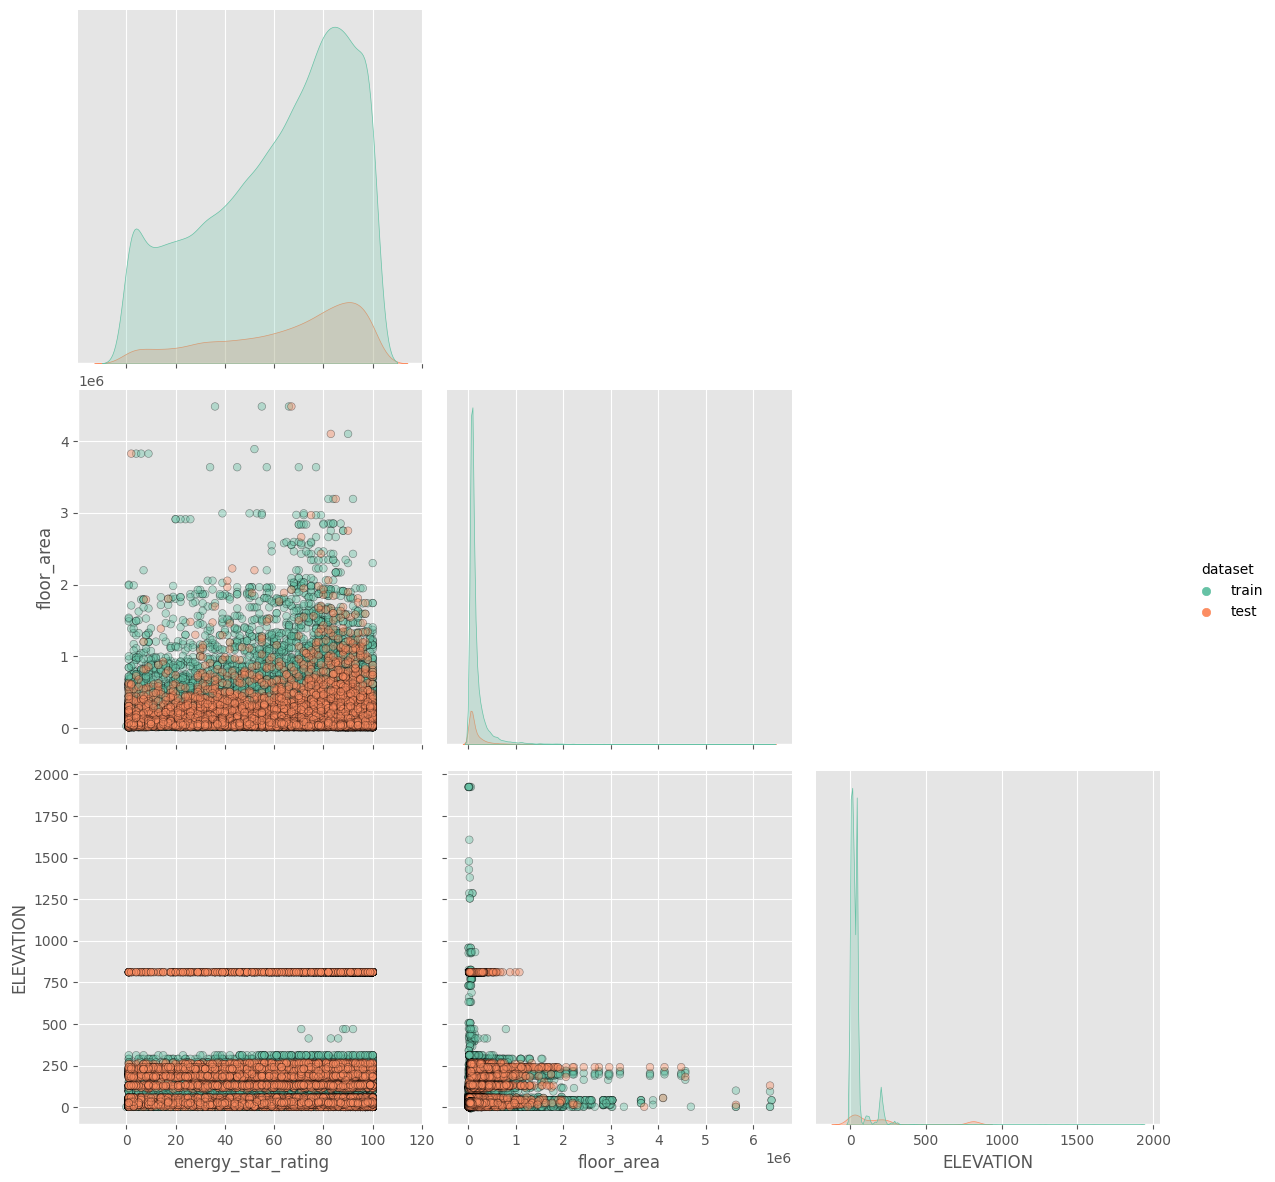

In [23]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">According to the average temperature (`avg_temp`), if we list states from warmest to coldest: State 1, State 10, State 2, and State 8. The range of temperatures of State1, State 6,  State 11 and State 4 are higher compared to the other states. </div>

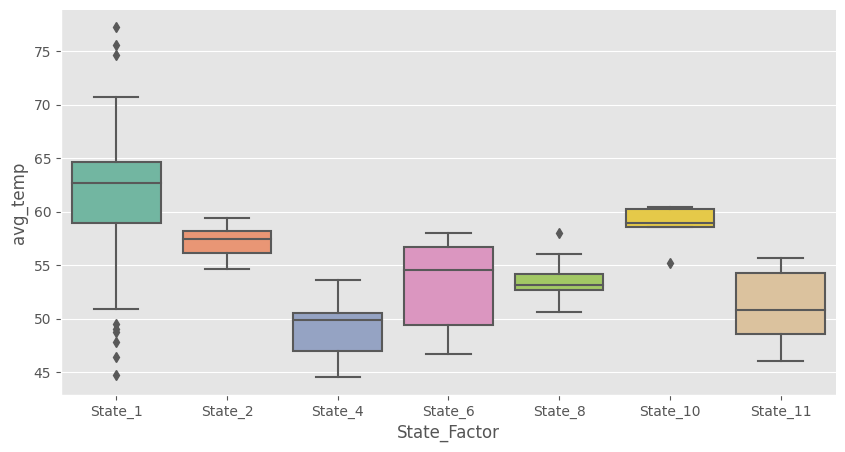

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');


# any one categorical col (with low unique vals)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Each month has unique temperature values between 31 and 59 which means the values in temperature volumes are highly repeated for the data points.</div>

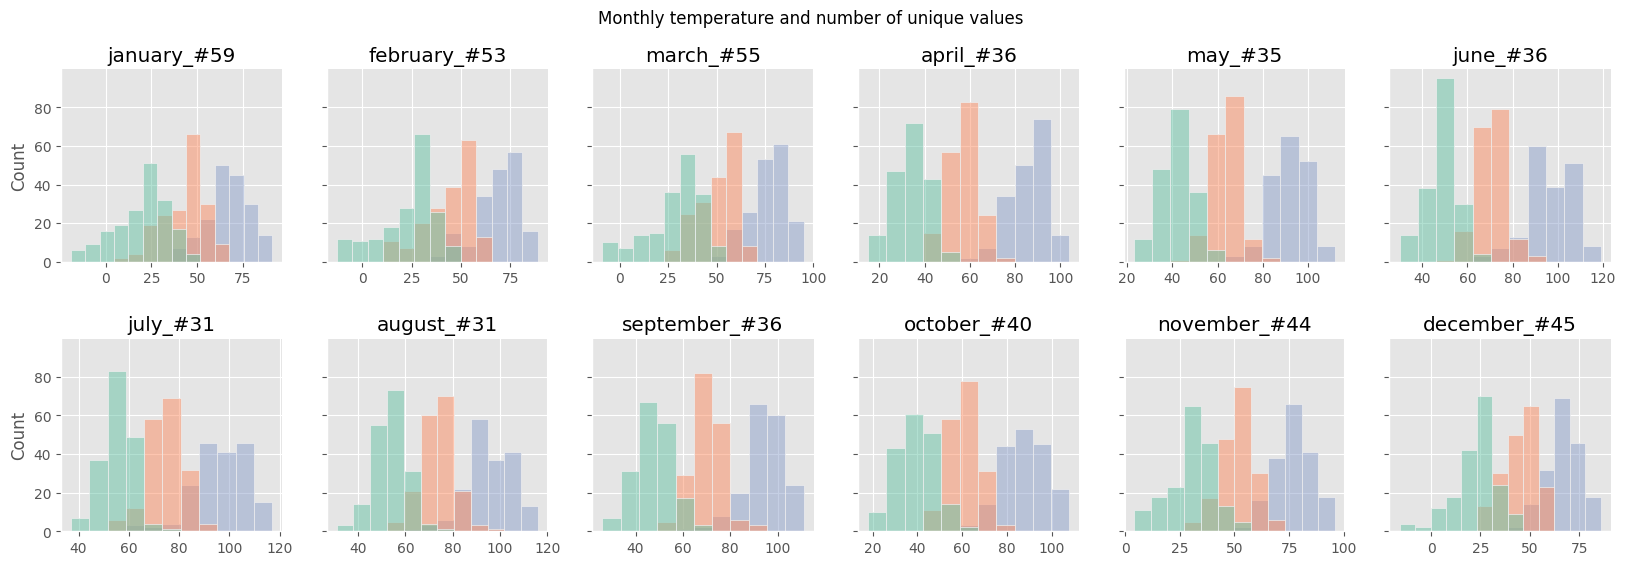

In [25]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Other weather related numerical columns also have few unique values.</div>

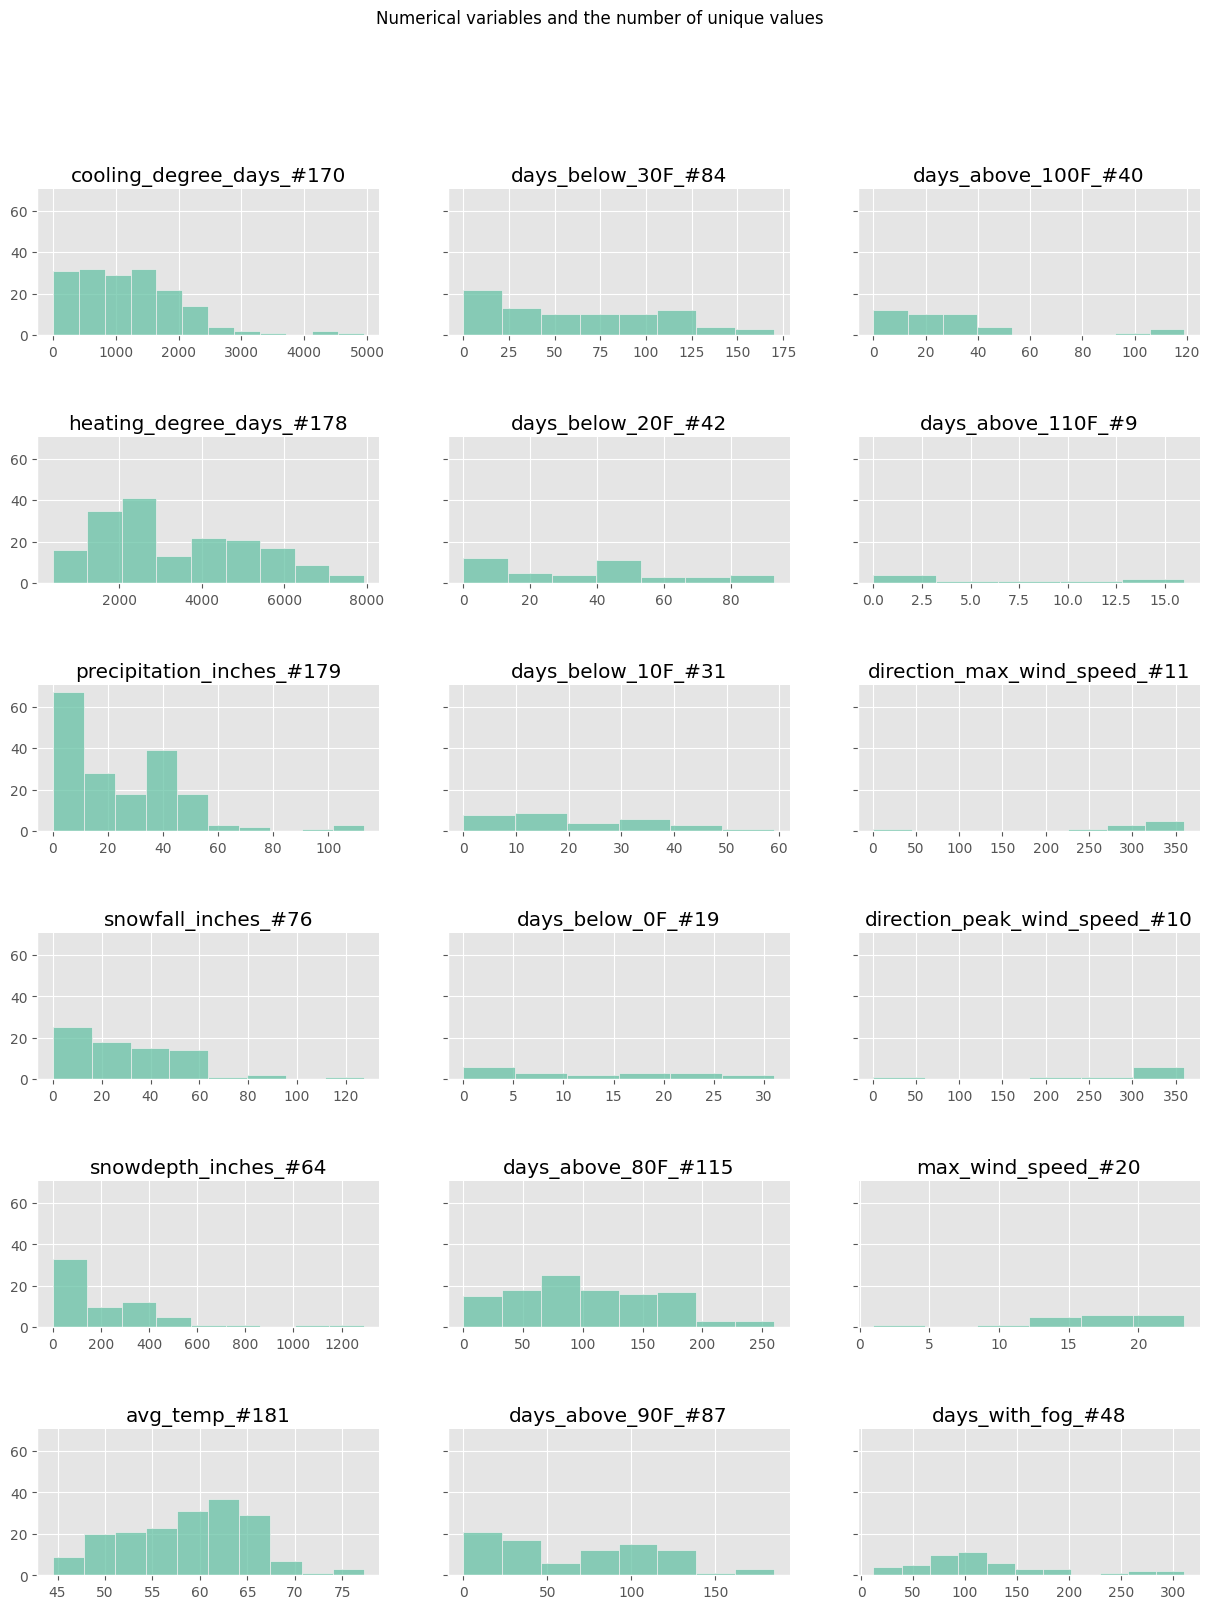

In [26]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

In [27]:

# # larger datasets
# find groups in the columns
# elevation, floor areas (dimentions)
# temperature
# wind




### <span style="font-family:cursive;text-align:center">📌Target Variable Exploration (EUI)</span>

In [28]:
# the target is skewed  (log-normal)
# the target has many outliers
# decision:  log-transform,  IQR outlier treatment

# perform:  we do not perform any transformation

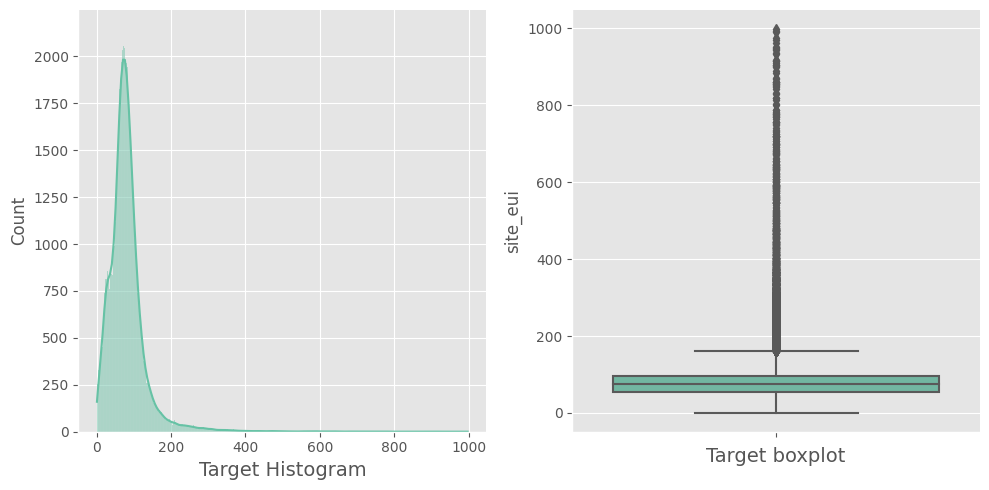

In [29]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">State 2 and 4 have slightly higher EUI and State 11 and 8 have lower EUI level.</div>

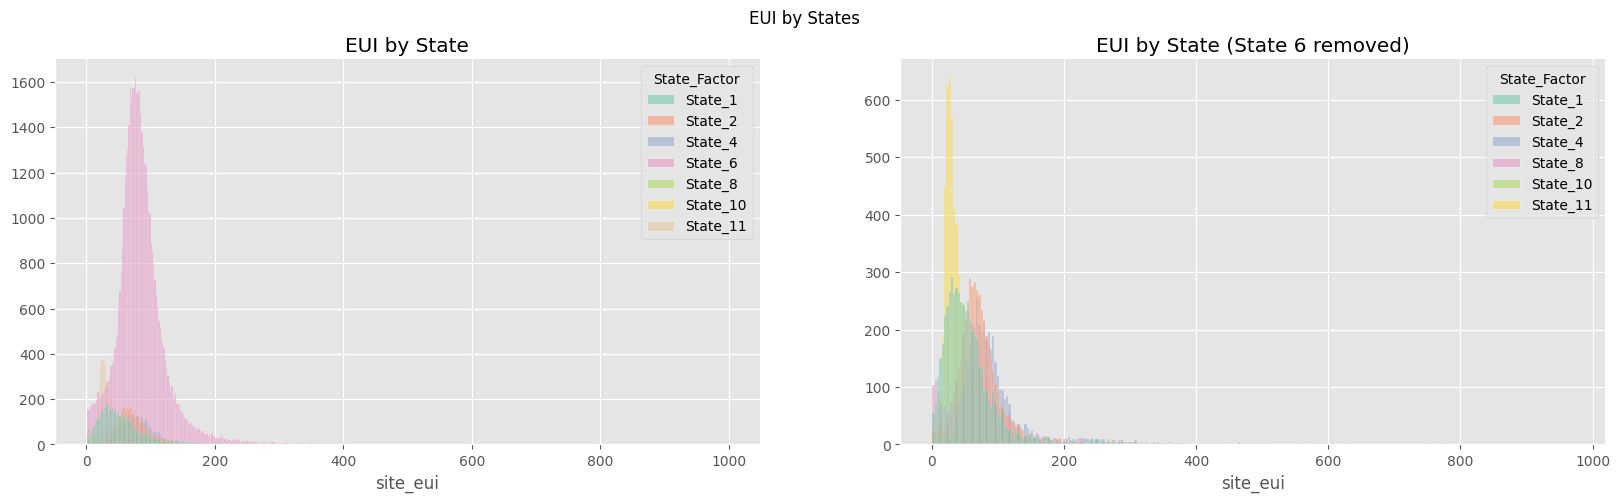

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

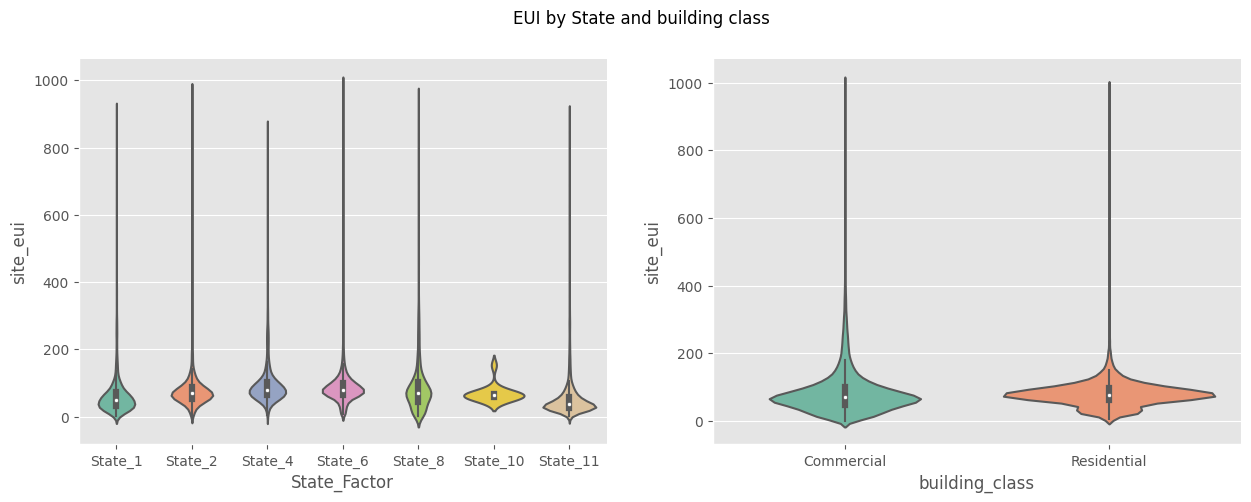

In [31]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">Labs and Data Centers have higher EUI compared to the other types of buildings. Grocery stores, Health Care Inpatient, Health Care Uncategorized, Health Care Outpatient, and Food service, restaurants have higher range of EUI. It could be the essential services must operate for longer hours, therefore, have higher EUI.</div>

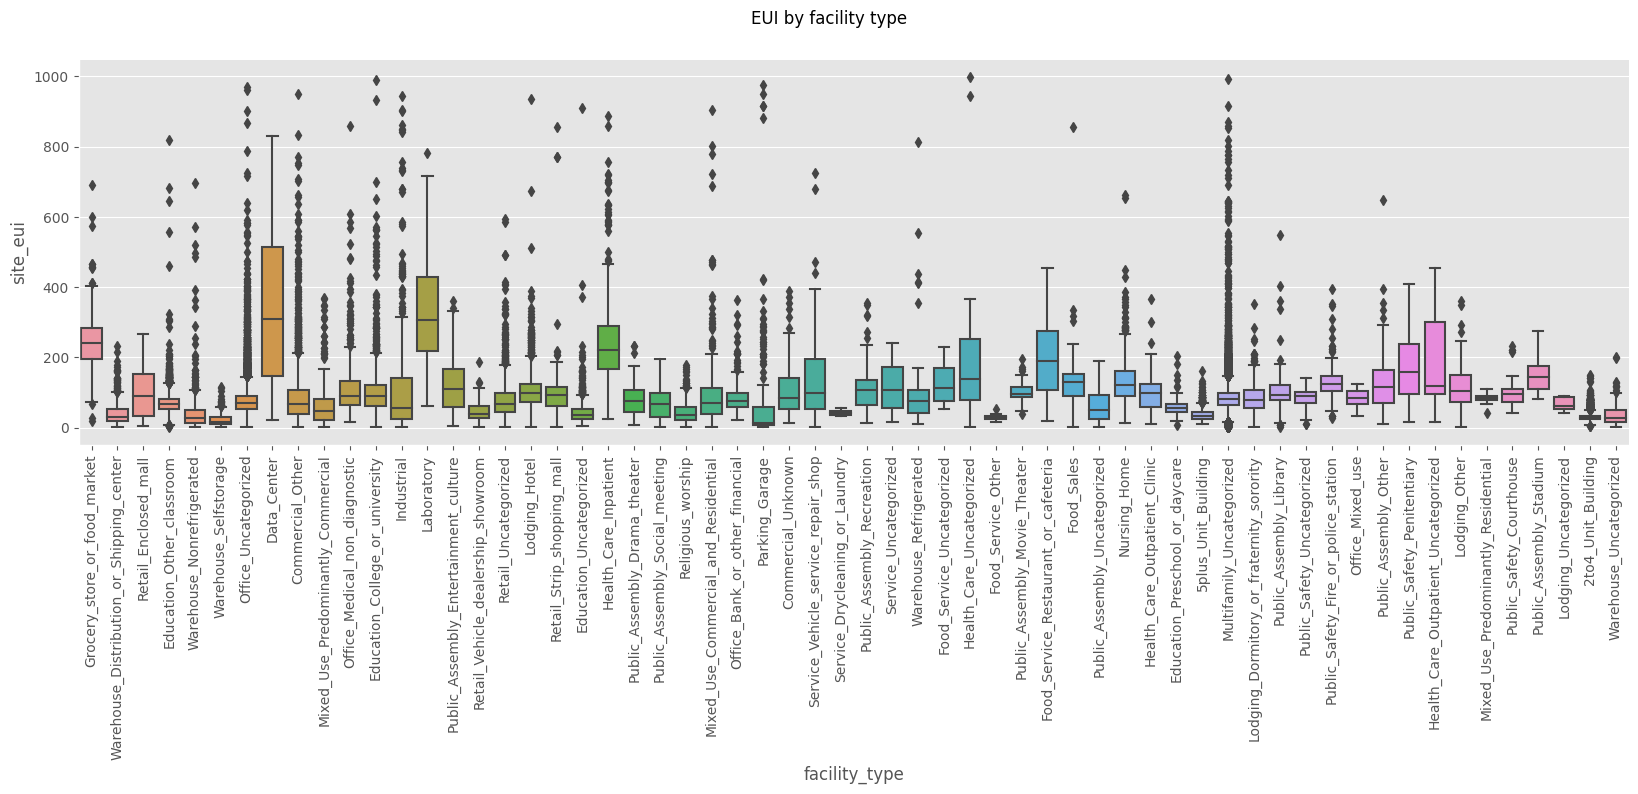

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">`floor_area` could have positive relationship with `EUI`. The younger buildings tend to have higher `EUI` which could be because building height and size have increased over the years. It looks like the Higher the `energy_star_rating` is, the lower the `EUI` becomes.</div>

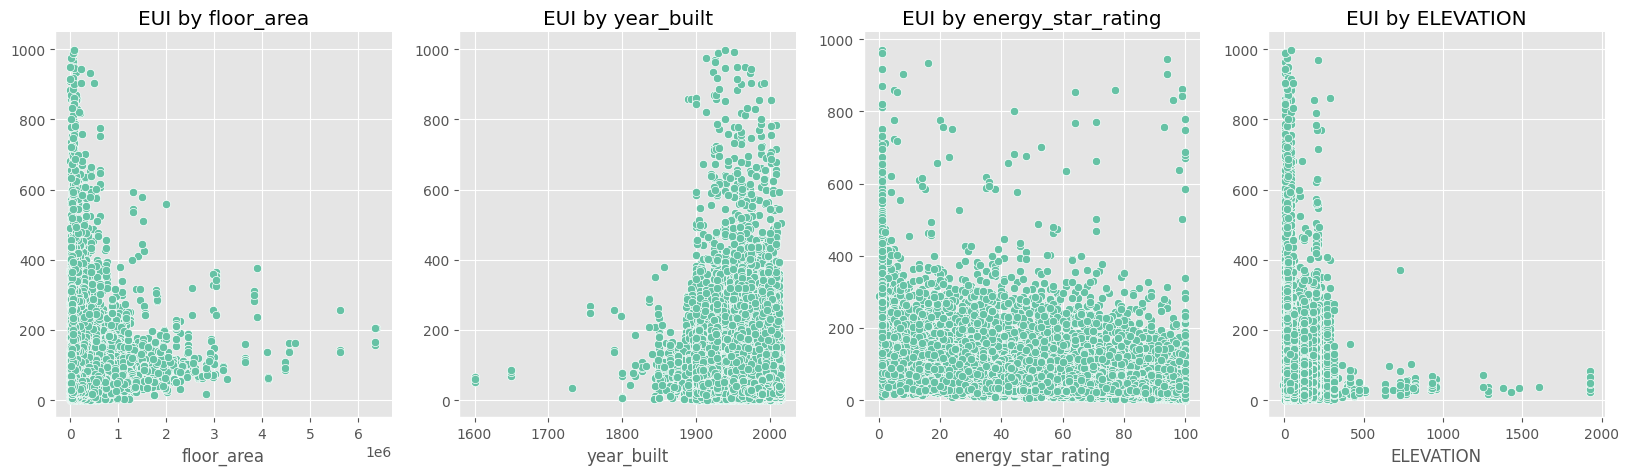

In [33]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">The most data points are in lower number of `cooling_degree_days` and higher number of`heating_degree_days`. The majority of the datapoints are also in the lower levels of `snowfall_inches` and `snowdepth_inches`. `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog` columns have the `NA` values of over 50%. No relationship between `EUI` and the weather related numerica columns can be observed from the plot.</div>

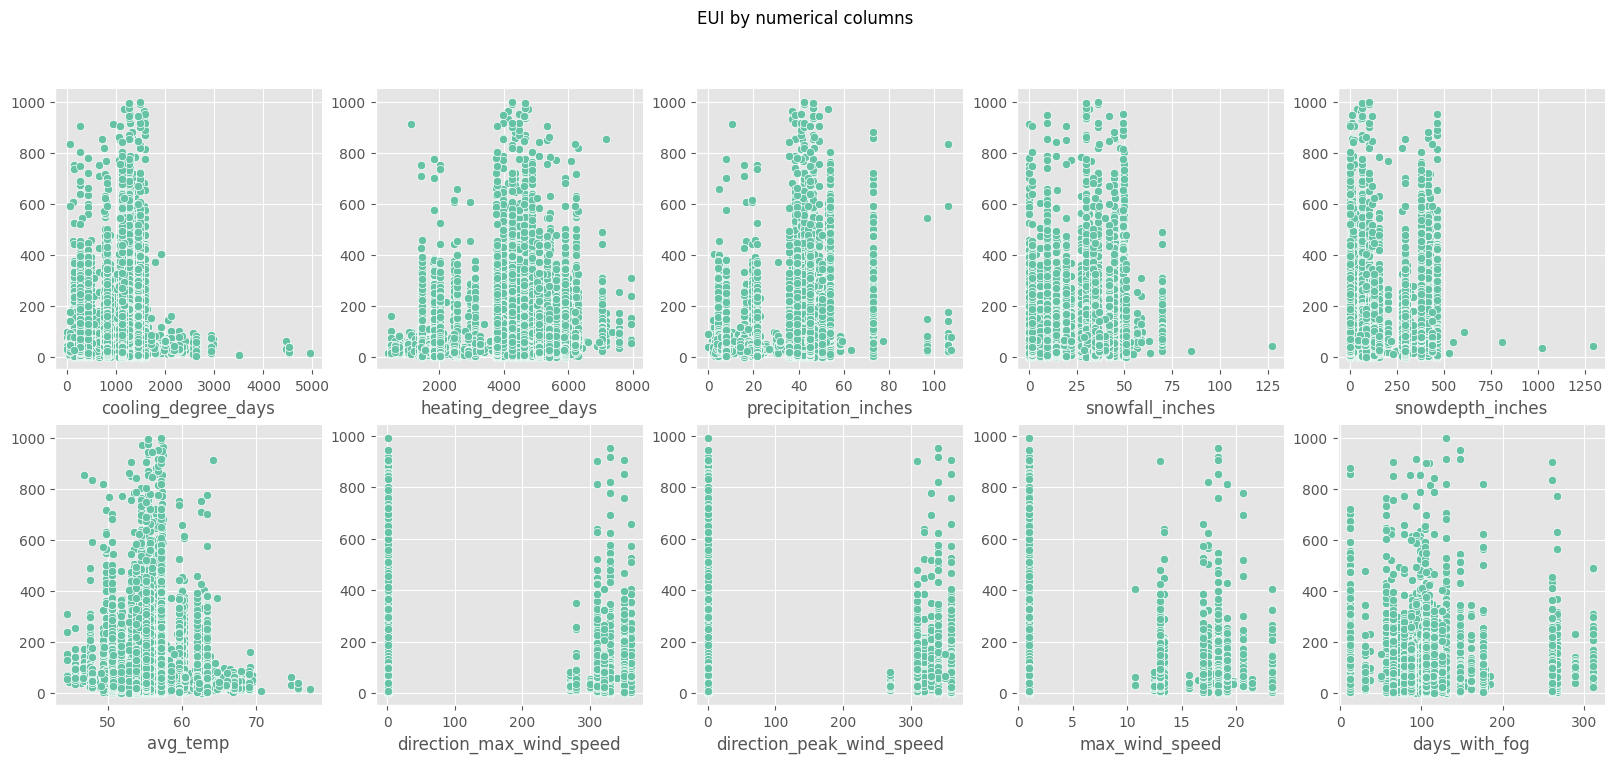

In [34]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>

- Categorical variables such as `State_Factor`, `building_class` and `facility_type` might have some correlation with `EUI`.
- `State_6` is not present in `test` set. State 6 removed training data should be tested.
- `floor_area`, `energe_star_rating` should be included in the modelling to be tested.
- From the plots, it's difficult to observe direct (linear) relationship between `EUI` and weather related variables. However, this doesn't deny non-linear relationships among the variables.
- Variables with more than 50% `NA` values should not be imputed (in my opinion) and better to be not included in the training set.
- Weather variables have few unique values repeated throughout the datapoints. Not sure how this duplicated values might affect the modeling and prediction.

# <span style="font-family:cursive;text-align:center">⚙️ Preprocessing</span>



<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    we will suppose that two  if two buildings have the same values for these features;   
they are the same building, in other words groupby_cols = (building_id)


Removing duplicates by clubbing similar building data
</div>

In [35]:
# null values,
# weather data points have a lot of repetition
# categories encoded

In [36]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [37]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    Null imputation for categorical values: <b>KNN Imputing</b>
</div>

In [38]:
df_all_one_hot = df_all.copy()

cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all_one_hot[col], dummy_na=False)
    for ohe_col in dummies:
        df_all_one_hot[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [39]:
df_all_one_hot

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,ohe_facility_type_Multifamily_Uncategorized,ohe_facility_type_Nursing_Home,ohe_facility_type_Office_Bank_or_other_financial,ohe_facility_type_Office_Medical_non_diagnostic,ohe_facility_type_Office_Mixed_use,ohe_facility_type_Office_Uncategorized,ohe_facility_type_Parking_Garage,ohe_facility_type_Public_Assembly_Drama_theater,ohe_facility_type_Public_Assembly_Entertainment_culture,ohe_facility_type_Public_Assembly_Library,ohe_facility_type_Public_Assembly_Movie_Theater,ohe_facility_type_Public_Assembly_Other,ohe_facility_type_Public_Assembly_Recreation,ohe_facility_type_Public_Assembly_Social_meeting,ohe_facility_type_Public_Assembly_Stadium,ohe_facility_type_Public_Assembly_Uncategorized,ohe_facility_type_Public_Safety_Courthouse,ohe_facility_type_Public_Safety_Fire_or_police_station,ohe_facility_type_Public_Safety_Penitentiary,ohe_facility_type_Public_Safety_Uncategorized,ohe_facility_type_Religious_worship,ohe_facility_type_Retail_Enclosed_mall,ohe_facility_type_Retail_Strip_shopping_mall,ohe_facility_type_Retail_Uncategorized,ohe_facility_type_Retail_Vehicle_dealership_showroom,ohe_facility_type_Service_Drycleaning_or_Laundry,ohe_facility_type_Service_Uncategorized,ohe_facility_type_Service_Vehicle_service_repair_shop,ohe_facility_type_Warehouse_Distribution_or_Shipping_center,ohe_facility_type_Warehouse_Nonrefrigerated,ohe_facility_type_Warehouse_Refrigerated,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_8,Residential,Multifamily_Uncategorized,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,...,1,0,0,

In [40]:
# This takes 1 hr, hence, unpickle the df1 and carry on with knn_imputing = False

knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    tmp.to_csv('imputer_tmp.csv', index=False)
    df1.to_csv('imputer_df1.csv', index=False)
    joblib.dump(imputer, 'knn_imputer.pkl')

else:
    df1 = pd.read_csv('imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]


# df1: no null values
# tmp: seperated columns
#     df1 + tmp  => final df



# null points  => neighbours (most gets imputed)

FileNotFoundError: [Errno 2] No such file or directory: 'imputer_df1.csv'

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    <b>Target encoding</b> for categorical columns.  
Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

Note: You can also use target encoding to convert categorical columns to numeric. 

> “features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.”

[Target Encoding Vs. One-hot Encoding with Simple Examples](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64)
<div>

In [43]:
df_all_te = df_all.copy()

cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all_te[f'te_{col}'] = encoder.fit_transform(df_all_te[col], df_all_te[target])

# <span style="font-family:cursive;text-align:center">Feature Engineering</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    <font size='3.5pt'><b>Weather based features</b></font>

we will extract new weather statistics from the building location weather features

In [44]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all_te.columns if 'temp' in col]

df_all_te['min_temp'] = df_all_te[temp].min(axis=1)
df_all_te['max_temp'] = df_all_te[temp].max(axis=1)
df_all_te['avg_temp'] = df_all_te[temp].mean(axis=1)
df_all_te['std_temp'] = df_all_te[temp].std(axis=1)
df_all_te['skew_temp'] = df_all_te[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all_te.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all_te['min_winter_temp'] = df_all_te[winter_temp].min(axis=1)
df_all_te['max_winter_temp'] = df_all_te[winter_temp].max(axis=1)
df_all_te['avg_winter_temp'] = df_all_te[winter_temp].mean(axis=1)
df_all_te['std_winter_temp'] = df_all_te[winter_temp].std(axis=1)
df_all_te['skew_winter_temp'] = df_all_te[winter_temp].skew(axis=1)
### spring
df_all_te['min_spring_temp'] = df_all_te[spring_temp].min(axis=1)
df_all_te['max_spring_temp'] = df_all_te[spring_temp].max(axis=1)
df_all_te['avg_spring_temp'] = df_all_te[spring_temp].mean(axis=1)
df_all_te['std_spring_temp'] = df_all_te[spring_temp].std(axis=1)
df_all_te['skew_spring_temp'] = df_all_te[spring_temp].skew(axis=1)
### summer
df_all_te['min_summer_temp'] = df_all_te[summer_temp].min(axis=1)
df_all_te['max_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['avg_summer_temp'] = df_all_te[summer_temp].mean(axis=1)
df_all_te['std_summer_temp'] = df_all_te[summer_temp].max(axis=1)
df_all_te['skew_summer_temp'] = df_all_te[summer_temp].max(axis=1)
## autumn
df_all_te['min_autumn_temp'] = df_all_te[autumn_temp].min(axis=1)
df_all_te['max_autumn_temp'] = df_all_te[autumn_temp].max(axis=1)
df_all_te['avg_autumn_temp'] = df_all_te[autumn_temp].mean(axis=1)
df_all_te['std_autumn_temp'] = df_all_te[autumn_temp].std(axis=1)
df_all_te['skew_autumn_temp'] = df_all_te[autumn_temp].skew(axis=1)

In [45]:
df_all_te['month_cooling_degree_days'] = df_all_te['cooling_degree_days']/12
df_all_te['month_heating_degree_days'] = df_all_te['heating_degree_days']/12

In [46]:
df_all_te[temp]

,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,avg_temp,min_temp,max_temp,std_temp,skew_temp
0,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,43,61.000000,84,36,55.116667,77,24,45.387097,68,61.816451,24.0,104.0,21.308416,0.281828
1,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,64.197549,41.0,95.0,14.980311,0.428700
2,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,49,69.580645,96,29,52.866667,75,28,48.580645,68,65.453067,28.0,106.0,21.906277,0.212369
3,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,62.281685,38.0,104.0,16.708230,0.725826
4,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,35,56.967742,85,31,52.516667,76,16,43.338710,68,58.126280,16.0,99.0,22.272150,0.113857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,53.227074,2.0,92.0,26.069571,-0.249731
85458,8,29.827586,62,4,33.896552,62,24,45.967742,79,18,49.931034,81,37,59.161290,89,45,70.465517,90,57,77.083333,96,54,75.725806,95,40,68.200000,96,24,55.258065,85,20,44.316667,71,12,35.129032,58,54.210864,4.0,96.0,26.198215,-0.136906
85459,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,53.227074,2.0,92.0,26.069571,-0.249731
85460,8,29.827586,62,4,33.896552,62,24,45.967742,79,18,49.931034,81,37,59.161290,89,45,70.465517,90,57,77.083333,96,54,75.725806,95,40,68.200000,96,24,55.258065,85,20,44.316667,71,12,35.129032,58,54.210864,4.0,96.0,26.198215,-0.136906


In [47]:
df_all_te['cooling_degree_days']

0         826
1         497
2        1319
3         342
4         303
         ... 
85457     866
85458    1114
85459     866
85460    1114
85461     866
Name: cooling_degree_days, Length: 85462, dtype: int64

In [48]:
df_all_te[['min_winter_temp', 'max_winter_temp', 'avg_winter_temp', 'std_winter_temp', 'skew_winter_temp',
           'min_spring_temp', 'max_spring_temp', 'avg_spring_temp', 'std_spring_temp', 'skew_spring_temp',
           'min_summer_temp', 'max_summer_temp', 'avg_summer_temp', 'std_summer_temp', 'skew_summer_temp',
           'min_autumn_temp', 'max_autumn_temp', 'avg_autumn_temp', 'std_autumn_temp', 'skew_autumn_temp']]

,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp
0,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253
1,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753
2,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329
3,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927
4,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2.0,73.0,34.781059,25.280345,0.107184,8.0,92.0,52.203584,27.390463,-0.033897,40.0,91.0,69.992399,91.0,91.0,17.0,91.0,55.995818,24.752362,-0.095805
85458,4.0,62.0,33.872574,22.974302,0.053637,18.0,89.0,53.673341,25.423297,0.041405,45.0,96.0,73.363851,96.0,96.0,20.0,96.0,55.974970,26.286606,0.078569
85459,2.0,73.0,34.781059,25.280345,0.107184,8.0,92.0,52.203584,27.390463,-0.033897,40.0,91.0,69.992399,91.0,91.0,17.0,91.0,55.995818,24.752362,-0.095805
85460,4.0,62.0,33.872574,22.974302,0.053637,18.0,89.0,53.673341,25.423297,0.041405,45.0,96.0,73.363851,96.0,96.0,20.0,96.0,55.974970,26.286606,0.078569


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    <font size='3.5pt'><b>Buildig based feature:</b></font>

we will extract building statistics

In [49]:
# total area
df_all_te['building_area'] = df_all_te['floor_area'] * df_all_te['ELEVATION']
# rating energy by floor
df_all_te['floor_energy_star_rating'] = df_all_te['energy_star_rating']/df_all_te['ELEVATION']


In [50]:
df_all_te[["floor_area", "ELEVATION", "energy_star_rating", "floor_energy_star_rating", "building_area"]]

,floor_area,ELEVATION,energy_star_rating,floor_energy_star_rating,building_area
0,10149.0,45.7,NaN,NaN,463809.3
1,10149.0,120.4,NaN,NaN,1221939.6
2,10149.0,59.1,NaN,NaN,599805.9
3,10149.0,59.1,NaN,NaN,599805.9
4,10755.0,9.1,NaN,NaN,97870.5
...,...,...,...,...,...
85457,900000.0,130.8,90.0,0.688073,117720000.0
85458,1179072.0,3.0,96.0,32.000000,3537216.0
85459,1179072.0,130.8,92.0,0.703364,154222617.6
85460,1195034.0,3.0,75.0,25.000000,3585102.0


### <span style="font-family:cursive;text-align:center">Checking target variable transformation</span>

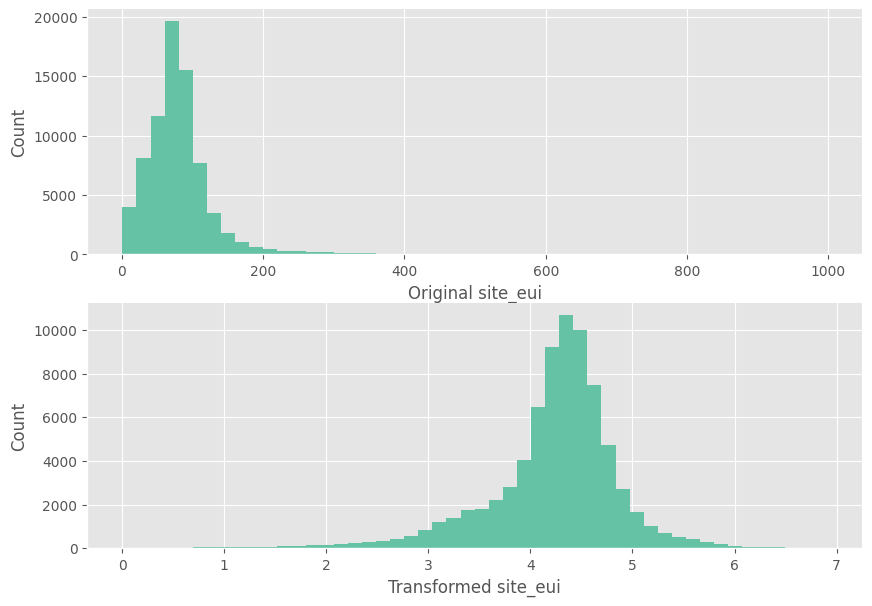

In [51]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

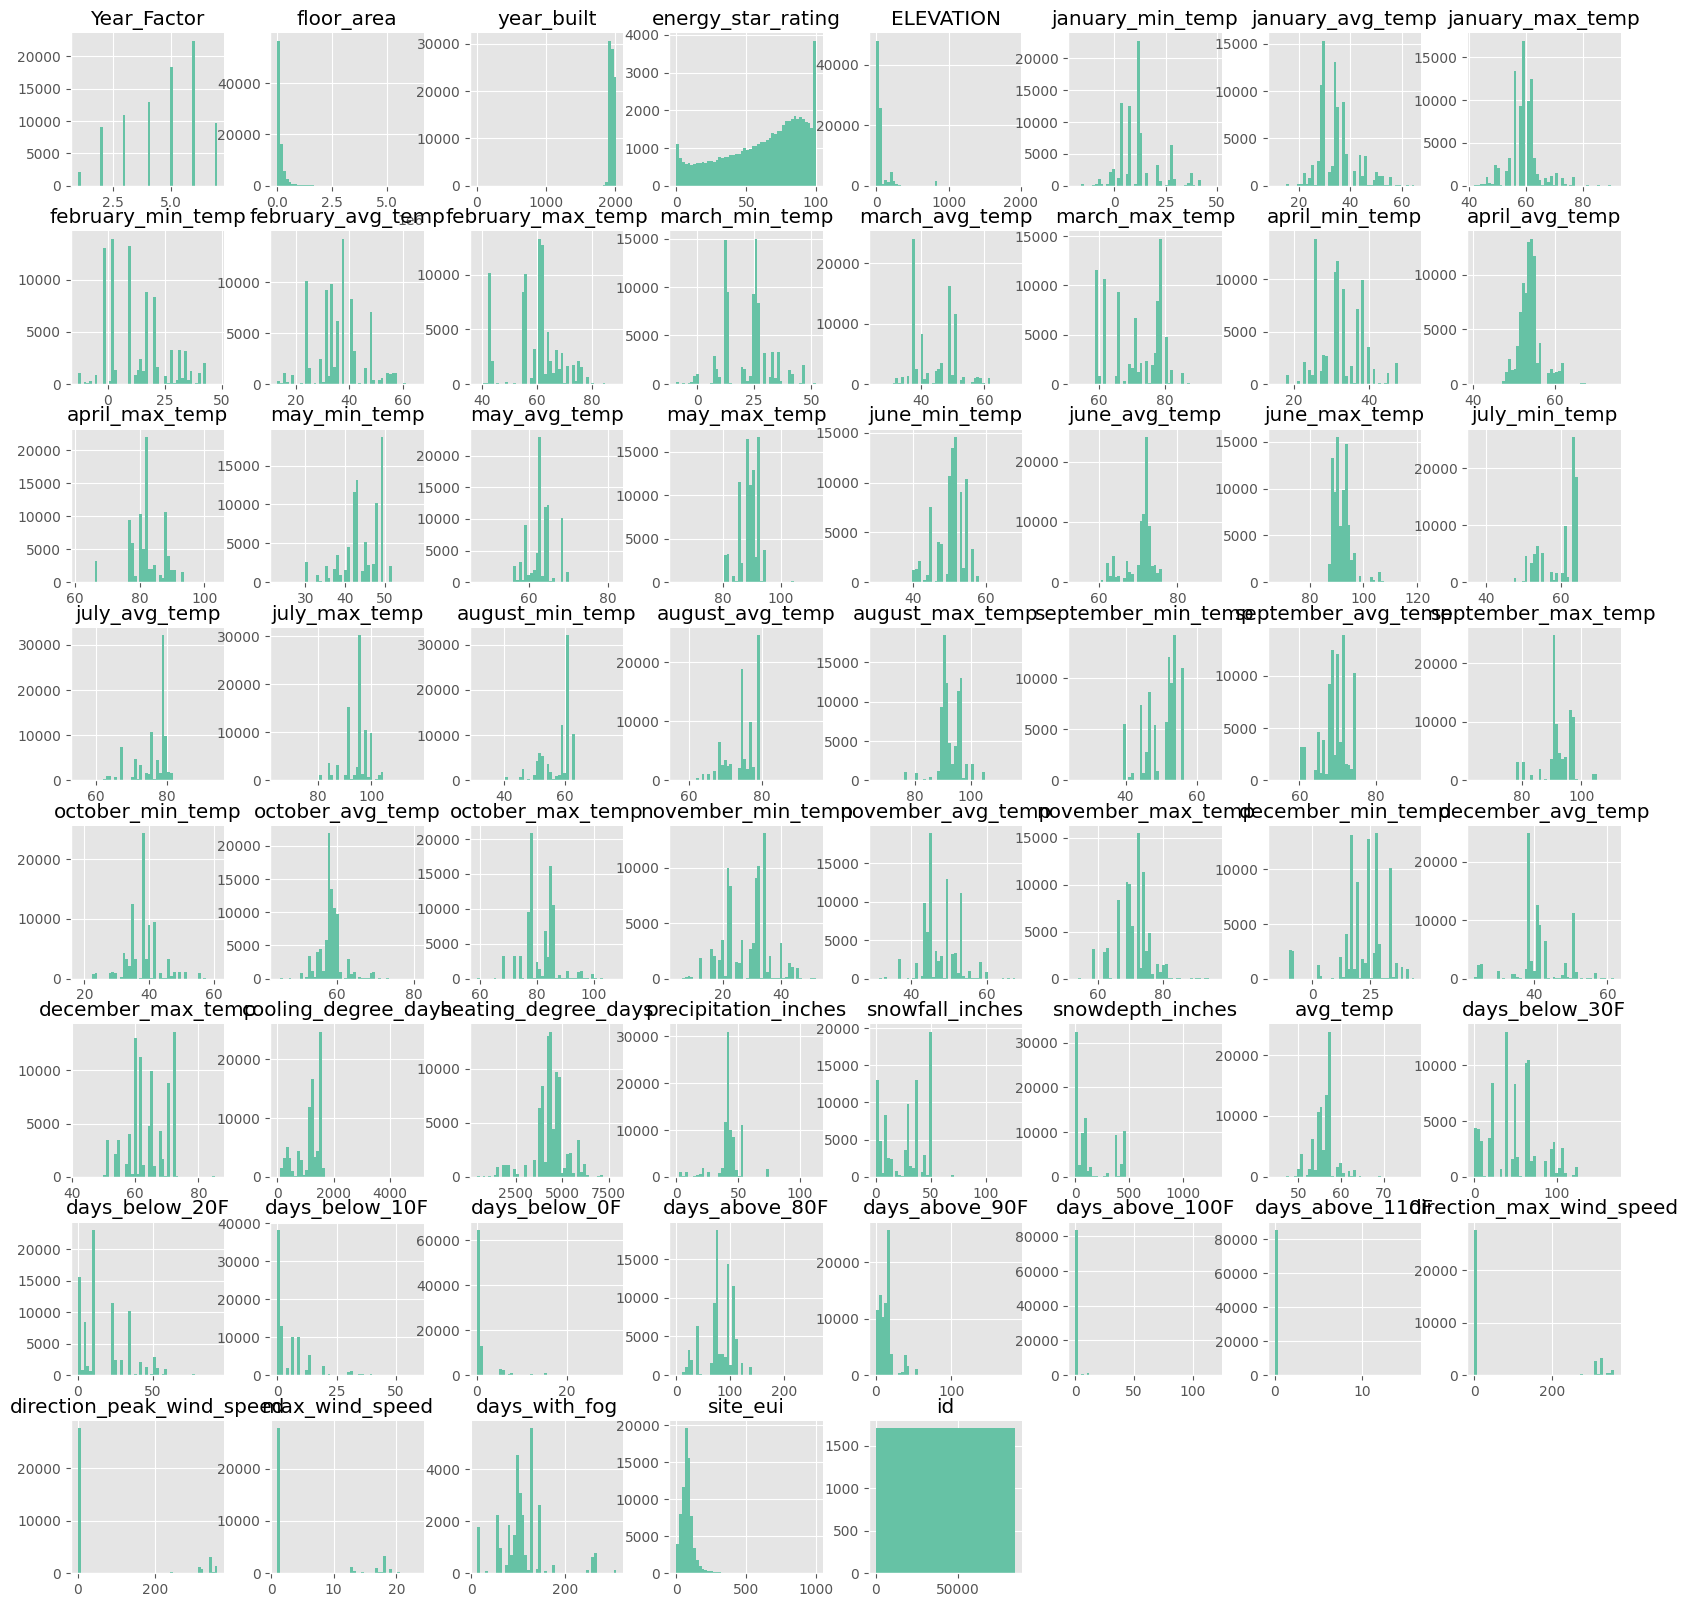

In [52]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [53]:
df_all_te[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.706906
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 
    Binarize very skewed variables

In [54]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all_te[var] = np.where(df_all_te[var]==0, 0, 1)

### <span style="font-family:cursive;text-align:center">Saving feature dataset</span>

In [55]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'feature_transformed_set_TEonly.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('feature_transformed_set_TEonly.pkl')

In [56]:
df_all_te.shape

(85462, 96)

In [57]:
df_all_te.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,days_with_fog,site_eui,id,dataset,te_State_Factor,te_building_class,te_facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,NaN,6.800000,1456,train,62.196194,85.755239,92.642037,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,NaN
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,NaN,8.200000,2673,train,62.196194,85.755239,92.642037,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,NaN
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,NaN,12.300000,3769,train,62.196194,85.755239,92.642037,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,NaN
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,NaN,NaN,76077,test,62.196194,85.755239,92.642037,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,NaN
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,NaN,63.083288,2144,train,62.196194,85.755239,92.642037,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,NaN


# <span style="font-family:cursive;text-align:center">🧰 Baseline Modelling</span>

In [58]:
# cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all_te.drop(columns=['dataset', 'id', 'site_eui', 'days_above_100F', 'days_above_110F']).columns:
    df_all_te[col] = df_all_te[col].astype('float64')

ValueError: could not convert string to float: 'State_1'

In [59]:
df_all_te

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,days_with_fog,site_eui,id,dataset,te_State_Factor,te_building_class,te_facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,NaN,6.800000,1456,train,62.196194,85.755239,92.642037,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,NaN
1,4.0,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,NaN,8.200000,2673,train,62.196194,85.755239,92.642037,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,NaN
2,5.0,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,NaN,12.300000,3769,train,62.196194,85.755239,92.642037,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,NaN
3,7.0,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,NaN,NaN,76077,test,62.196194,85.755239,92.642037,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,NaN
4,3.0,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,NaN,63.083288,2144,train,62.196194,85.755239,92.642037,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7.0,State_8,Residential,Multifamily_Uncategorized,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,...,NaN,N

In [60]:
train = df_all_te[df_all_te['dataset']=='train']
test = df_all_te[df_all_te['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

In [61]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

### <span style="font-family:cursive;text-align:center">Catboost</span>

In [62]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]

In [63]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100
                        )

In [64]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

NameError: name 'X_train' is not defined

In [65]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------


NameError: name 'y_test' is not defined

### <span style="font-family:cursive;text-align:center">XGBoost</span>

In [66]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

NameError: name 'X_train' is not defined

In [67]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------


NameError: name 'y_test' is not defined

### <span style="font-family:cursive;text-align:center">RandomForest</span>

In [68]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

NameError: name 'X_train' is not defined

In [69]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------


NameError: name 'y_test' is not defined

### <span style="font-family:cursive;text-align:center">Lasso Regression</span>

In [70]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

NameError: name 'X_train' is not defined

In [71]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------


NameError: name 'y_test' is not defined

# <span style="font-family:cursive;text-align:center">Model Evaluation</span>

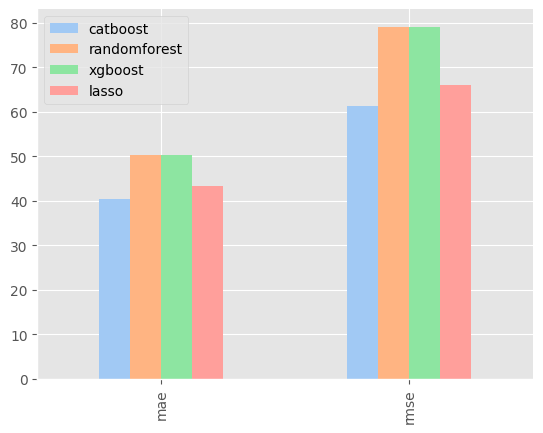

In [72]:
error_rec = {
    "catboost": {
        "mae": 40.29268484855883,
        "rmse": 61.19378120765249,
    },
    "randomforest": {
        "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "xgboost": {
         "mae": 50.1839889322522,
        "rmse": 79.12972350643851,
    },
    "lasso": {
         "mae": 43.26164501092259,
        "rmse": 66.08328222674918,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

# <span style="font-family:cursive;text-align:center">Hyperparameter Tuning</span>

### <span style="font-family:cursive;text-align:center">Using CrossValidation on CatBoost</span>

In [ ]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.1178972	test: 57.0630160	best: 57.0630160 (0)	total: 1.12s	remaining: 9m 18s


### <span style="font-family:cursive;text-align:center">Using Optuna with Random Forest</span> 

In [ ]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()



In [ ]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [ ]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

In [ ]:
rf_tuned_model.fit(X_train, y_train)

### <span style="font-family:cursive;text-align:center">Final Evaluation</span>

In [ ]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

In [ ]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

### <span style="font-family:cursive;text-align:center">Saving Models</span> 

In [ ]:
with open('rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [ ]:
## Load models here
load = False
if load:
    with open('rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)

# <span style="font-family:cursive;text-align:center">Explainable AI</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> 

we will extract new weather statistics from the building location weather featurespick your sample to study the model upon

In [ ]:
size = 2000

sample_exists = False

if sample_exists:
    sample_set = pd.read_csv('data/shap/sample2000.csv')
else:
    sample_set = X_test.sample(size)
sample_set

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;"> calculate shap values

In [ ]:
is_saved = False

if is_saved:
    with open('data/shap/shap_values_sample2000.pkl', 'rb') as f:
        shap_values = joblib.load(f)
else:
    shap_values = shap.TreeExplainer(rf).shap_values(sample_set)

In [ ]:
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, sample_set)

In [ ]:
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], sample_set.iloc[0:limit,:])

In [ ]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], sample_set.iloc[row])

In [ ]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

In [ ]:
shap.dependence_plot('State_Factor', shap_values, sample_set)

In [ ]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=sample_set.columns.tolist()
                                      )

In [ ]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=sample_set.columns.tolist())

In [ ]:
limit = 500
shap.plots.heatmap(shap.TreeExplainer(rf_tuned_model, data=sample_set)(sample_set[:limit]), max_display=15)